In [1]:
import numpy as np
import midi_manipulation
import matplotlib.pyplot as plt
import tensorflow as tf
from midi2audio import FluidSynth

%matplotlib inline
from IPython.display import Audio, display

In [2]:
with open('../audio_files/midi_input/sonic_starlight_zone.mid', 'rb') as f:
    song = np.array(midi_manipulation.midiToNoteStateMatrix(f))

In [3]:
song[2*200:3*200].shape

(200, 156)

In [4]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps = 80
num_batches = song.shape[0] // num_timesteps
height = num_timesteps
width = 2*note_range
n_visible = 2 * note_range * num_timesteps
n_hidden = 32

num_epochs = 2000
batch_size = 1

z_dim = 500
X_dim = width * height
h_dim = n_hidden

initializer = tf.contrib.layers.xavier_initializer()
print(note_range)

78


In [5]:
#X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

#Q_W1 = tf.get_variable('Q_W1', shape=[X_dim, h_dim], initializer=initializer)
#Q_b1 = tf.get_variable('Q_b1', shape=[h_dim], initializer=initializer)

X = tf.placeholder(tf.float32, shape=[None, height, width, 1])

conv1_kernel = tf.get_variable('conv1', shape=[(height - 79) ,(width - 79),1,6], initializer=initializer)
conv1_bias = tf.get_variable('conv1_b', shape=[6])

conv2_kernel = tf.get_variable('conv2', shape=[5, 5 , 6 , 6], initializer=initializer)
conv2_bias = tf.get_variable('conv2_b', shape=[6])

f_dim = 18*18*6

Q_W2_mu = tf.get_variable('Q_W2_mu', shape=[f_dim, z_dim], initializer=initializer)
Q_b2_mu = tf.get_variable('Q_b2_mu', shape=[z_dim], initializer=initializer)

Q_W2_sigma = tf.get_variable('Q_W2_sigma', shape=[f_dim, z_dim], initializer=initializer)
Q_b2_sigma = tf.get_variable('Q_b2_sigma', shape=[z_dim], initializer=initializer)

def Q(X, keep_prob=1.0):
    #Conv layer, output is [80, 80, 6]
    conv1 = tf.nn.conv2d(X, conv1_kernel, [1,1,1,1], "VALID")
    preact1 = tf.nn.bias_add(conv1, conv1_bias)
    relu1 = tf.nn.relu(preact1)
    #pool1 output: [40, 40, 6]
    pool1 = tf.nn.max_pool(relu1, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
    
    #Conv2 layer, output is [36, 36, 6]
    conv2 = tf.nn.conv2d(pool1, conv2_kernel, [1,1,1,1], "VALID")
    preact2 = tf.nn.bias_add(conv2, conv2_bias)
    relu2 = tf.nn.relu(preact2)
    #pool1 output: [18, 18, 6]
    pool2 = tf.nn.max_pool(relu2, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
    
    h = tf.contrib.layers.flatten(pool2)
    
    drop = tf.nn.dropout(h, keep_prob=keep_prob)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

In [6]:
P_W1 = tf.get_variable('P_W1', shape=[z_dim, h_dim], initializer=initializer)
P_b1 = tf.get_variable('P_b1', shape=[h_dim], initializer=initializer)

P_W2 = tf.get_variable('P_W2', shape=[h_dim, X_dim], initializer=initializer)
P_b2 = tf.get_variable('P_b2', shape=[X_dim], initializer=initializer)

def P(z, keep_prob=1.0):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    drop = tf.nn.dropout(h, keep_prob=keep_prob)
    logits = tf.matmul(drop, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

In [7]:
z_mu, z_logvar = Q(X, keep_prob=0.6)
z_sample = sample_z(z_mu, z_logvar)
out_samples, logits = P(z_sample, keep_prob=0.6)

# Sampling from random z
X_samples, _ = P(z)

X_labels = tf.reshape(X, [-1, width*height])

recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X_labels), 1)
#kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.square(z_logvar) - tf.log(tf.square(z_logvar)) - 1,1) 

loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(loss)
writer = tf.summary.FileWriter('./tf_logs/', graph=tf.get_default_graph())
saver = tf.train.Saver()

('Iter: ', 0)
('Loss: ', 9198.5254)
('KL Loss:', array([ 514.02905273], dtype=float32))


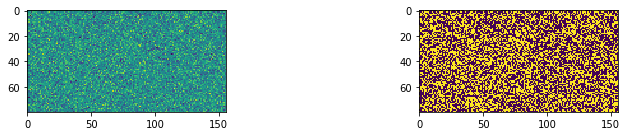

('Iter: ', 100)
('Loss: ', 1142.8024)
('KL Loss:', array([ 108.20787048], dtype=float32))


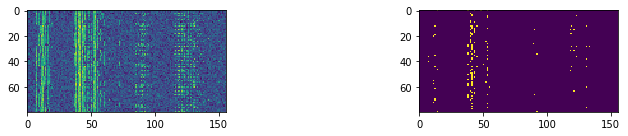

('Iter: ', 200)
('Loss: ', 876.0979)
('KL Loss:', array([ 99.31151581], dtype=float32))


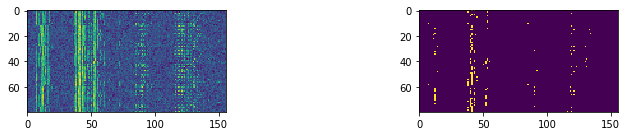

('Iter: ', 300)
('Loss: ', 788.59344)
('KL Loss:', array([ 68.31498718], dtype=float32))


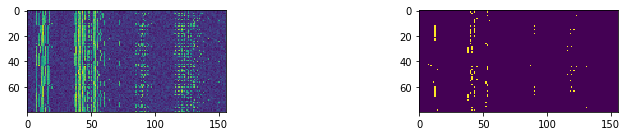

('Iter: ', 400)
('Loss: ', 784.61005)
('KL Loss:', array([ 50.65034485], dtype=float32))


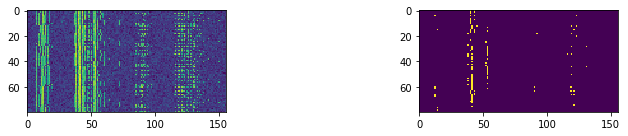

('Iter: ', 500)
('Loss: ', 643.47412)
('KL Loss:', array([ 73.80442047], dtype=float32))


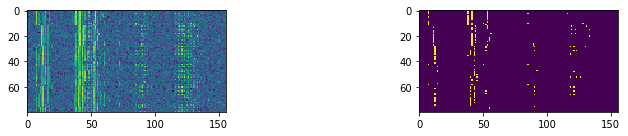

('Iter: ', 600)
('Loss: ', 333.09259)
('KL Loss:', array([ 107.15763855], dtype=float32))


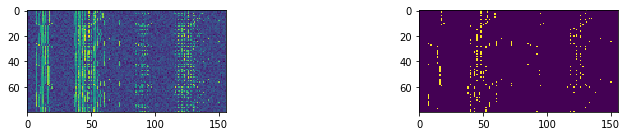

('Iter: ', 700)
('Loss: ', 442.18073)
('KL Loss:', array([ 150.93571472], dtype=float32))


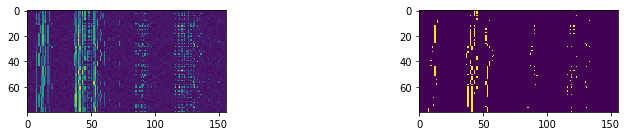

('Iter: ', 800)
('Loss: ', 173.62393)
('KL Loss:', array([ 119.487854], dtype=float32))


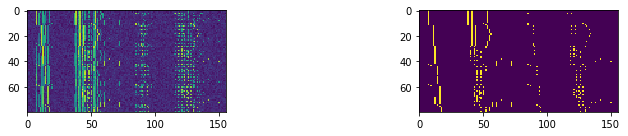

('Iter: ', 900)
('Loss: ', 242.77634)
('KL Loss:', array([ 102.72379303], dtype=float32))


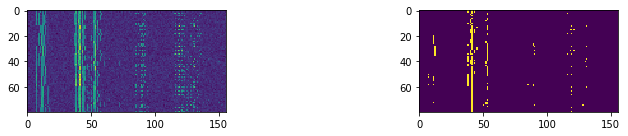

('Iter: ', 1000)
('Loss: ', 411.95123)
('KL Loss:', array([ 97.43300629], dtype=float32))


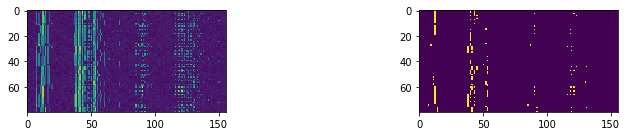

('Iter: ', 1100)
('Loss: ', 203.79553)
('KL Loss:', array([ 115.06760406], dtype=float32))


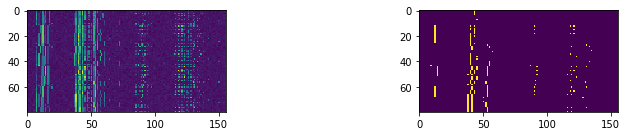

('Iter: ', 1200)
('Loss: ', 344.93893)
('KL Loss:', array([ 95.87889099], dtype=float32))


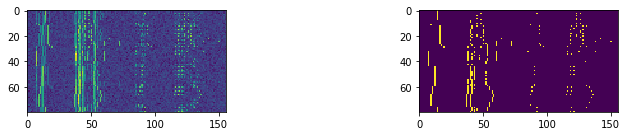

('Iter: ', 1300)
('Loss: ', 171.36111)
('KL Loss:', array([ 79.65779877], dtype=float32))


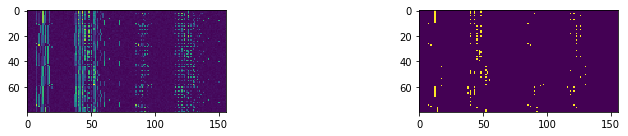

('Iter: ', 1400)
('Loss: ', 240.65672)
('KL Loss:', array([ 68.0464325], dtype=float32))


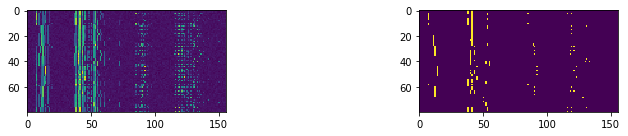

('Iter: ', 1500)
('Loss: ', 135.94974)
('KL Loss:', array([ 72.52571106], dtype=float32))


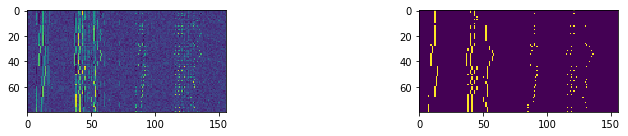

('Iter: ', 1600)
('Loss: ', 104.0395)
('KL Loss:', array([ 64.46376038], dtype=float32))


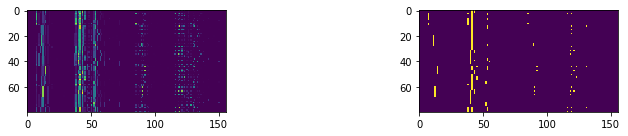

('Iter: ', 1700)
('Loss: ', 203.3968)
('KL Loss:', array([ 61.79229736], dtype=float32))


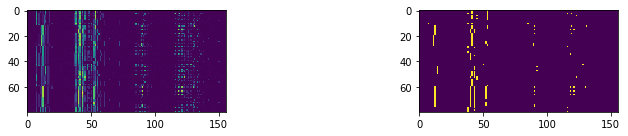

('Iter: ', 1800)
('Loss: ', 211.74725)
('KL Loss:', array([ 60.27497482], dtype=float32))


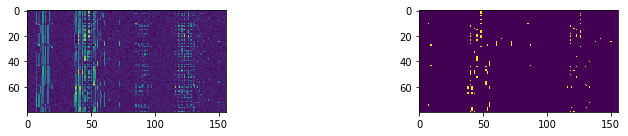

('Iter: ', 1900)
('Loss: ', 184.45798)
('KL Loss:', array([ 69.34343719], dtype=float32))


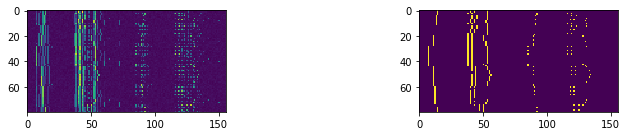

('Iter: ', 2000)
('Loss: ', 120.53003)
('KL Loss:', array([ 78.68675995], dtype=float32))


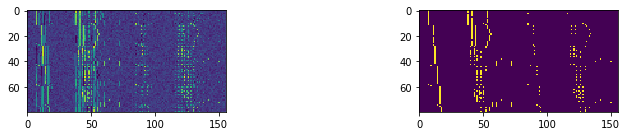

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    while i <= num_epochs:
        #s = song[20:20+num_timesteps,:].reshape(1,num_timesteps*2*note_range)
        s = song[20:20+num_timesteps,:].reshape(1, height, width, 1)
        for ind in range(0, num_batches):
            X_mb = song[(ind*num_timesteps):num_timesteps*(ind + 1), :].reshape(1, height, width, 1)
            _,loss_out, kl = sess.run([solver, loss, kl_loss], feed_dict={X: X_mb})
            
            if i % 100 == 0:
                print('Iter: ', i)
                print('Loss: ', loss_out)
                print('KL Loss:', kl)
                
                #Random samples
                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim)})
                
                samples = samples.reshape((num_timesteps, 2*note_range))
                thresh_S = samples >= 0.5
                plt.figure(figsize=(12,2))
                plt.subplot(1,2,1)
                plt.imshow(samples)
                plt.subplot(1,2,2)
                plt.imshow(thresh_S)
                plt.tight_layout()
                plt.pause(0.1)
            i += 1
        saver.save(sess, "./checkpoints/vae_sarias.ckpt")

In [10]:
midi_manipulation.noteStateMatrixToMidi(song[20:100,:], "out/test")

IOError: [Errno 2] No such file or directory: 'out/test.mid'

In [11]:
song[20:20+num_timesteps,:].reshape(num_timesteps*2*note_range).shape

(31200,)

In [13]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/vae_sarias.ckpt')
    #Random samples
    samples = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim)})

    samples = samples.reshape((num_timesteps, 2*note_range))
    thresh_S = samples >= 0.5
    midi_manipulation.noteStateMatrixToMidi(thresh_S, "../audio_files/output/sonic_test")
    
#FluidSynth().midi_to_audio('../audio_files/output/sonic_test.mid', 'out/test.wav')
#display(Audio('out/test.wav'))

INFO:tensorflow:Restoring parameters from ./checkpoints/vae_sarias.ckpt


In [11]:
with open('../audio_files/midi/sarias_song_no_perc.mid', 'rb') as f:
    song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
    
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/vae_sarias.ckpt')
    s = song[20:20+num_timesteps,:].reshape(1,num_timesteps*2*note_range)
    #Random samples
    samples = sess.run(out_samples, feed_dict={X: s})

    samples = samples.reshape((num_timesteps, 2*note_range))
    thresh_S = samples >= 0.5
    midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/vae_sarias_song_out")


IOError: [Errno 2] No such file or directory: '../audio_files/midi/sarias_song_no_perc.mid'